100%|██████████| 170M/170M [00:03<00:00, 46.8MB/s]


Training RBM 1: 3072 -> 1024
Epoch 1, Loss: 3066.2139
Epoch 2, Loss: 3437.2973
Epoch 3, Loss: 3756.7850
Epoch 4, Loss: 3964.9197
Epoch 5, Loss: 4079.2946
Epoch 6, Loss: 4136.7877
Epoch 7, Loss: 4162.8686
Epoch 8, Loss: 4175.8612
Epoch 9, Loss: 4180.3411
Epoch 10, Loss: 4183.6819


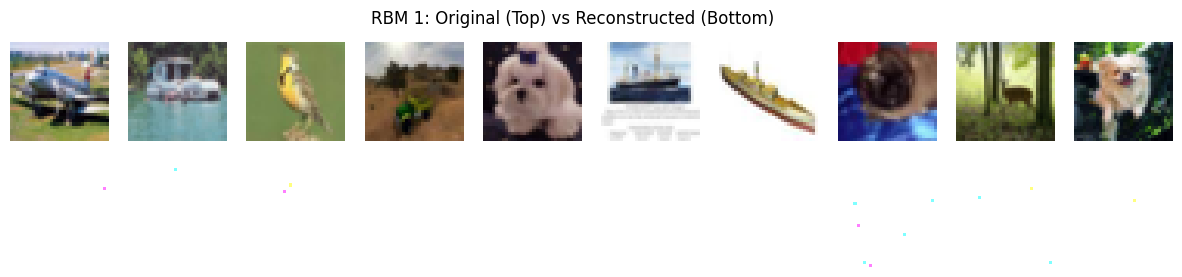

Training RBM 2: 1024 -> 512
Epoch 1, Loss: 1037.3298
Epoch 2, Loss: 1152.6282
Epoch 3, Loss: 1256.6807
Epoch 4, Loss: 1324.3379
Epoch 5, Loss: 1361.5307
Epoch 6, Loss: 1379.4499
Epoch 7, Loss: 1388.2463
Epoch 8, Loss: 1391.8293
Epoch 9, Loss: 1393.9456
Epoch 10, Loss: 1394.5224
DBN final feature shape: torch.Size([64, 512])


In [1]:
# Deep Belief Network (DBN) with RBMs on CIFAR-10 in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
rbm_hidden_units = [1024, 512]
epochs = 10
lr = 0.001
input_size = 32 * 32 * 3

# CIFAR-10 Data loading and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# RBM class for CIFAR-10
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_from_p(self, p):
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h, self.sample_from_p(p_h)

    def h_to_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return p_v, self.sample_from_p(p_v)

    def forward(self, v):
        p_h, h = self.v_to_h(v)
        p_v, v1 = self.h_to_v(h)
        return v, v1

    def contrastive_divergence(self, v):
        v0 = v
        p_h0, h0 = self.v_to_h(v0)
        p_v1, v1 = self.h_to_v(h0)
        p_h1, h1 = self.v_to_h(v1)

        self.W.grad = torch.matmul(h0.t(), v0) - torch.matmul(h1.t(), v1)
        self.v_bias.grad = torch.sum(v0 - v1, dim=0)
        self.h_bias.grad = torch.sum(h0 - h1, dim=0)

        return torch.mean(torch.sum((v0 - v1)**2, dim=1))

# Train RBMs for DBN
rbms = []
for idx, hidden_units in enumerate(rbm_hidden_units):
    rbm = RBM(input_size, hidden_units).to(device)
    optimizer = torch.optim.SGD(rbm.parameters(), lr=lr)
    print(f"Training RBM {idx+1}: {input_size} -> {hidden_units}")

    for epoch in range(epochs):
        epoch_loss = 0
        for batch, _ in train_loader:
            batch = batch.view(-1, input_size).to(device)
            optimizer.zero_grad()
            loss = rbm.contrastive_divergence(batch)
            rbm.W.grad /= batch.size(0)
            rbm.v_bias.grad /= batch.size(0)
            rbm.h_bias.grad /= batch.size(0)
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Visualize reconstruction (limited to first RBM only for clarity)
    if idx == 0:
        sample_batch, _ = next(iter(train_loader))
        sample_batch = sample_batch.view(-1, input_size).to(device)
        with torch.no_grad():
            v, v_recon = rbm(sample_batch)
        v = v.view(-1, 3, 32, 32).cpu()
        v_recon = v_recon.view(-1, 3, 32, 32).cpu()

        fig, axes = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(10):
            axes[0, i].imshow(v[i].permute(1, 2, 0) * 0.5 + 0.5)
            axes[0, i].axis('off')
            axes[1, i].imshow(v_recon[i].permute(1, 2, 0) * 0.5 + 0.5)
            axes[1, i].axis('off')
        plt.suptitle(f"RBM {idx+1}: Original (Top) vs Reconstructed (Bottom)")
        plt.show()

    rbms.append(rbm)
    input_size = hidden_units

# DBN forward class
class DBN(nn.Module):
    def __init__(self, rbms):
        super(DBN, self).__init__()
        self.rbms = rbms

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        for rbm in self.rbms:
            x, _ = rbm.v_to_h(x)
        return x

# Forward sample through DBN
dbn = DBN(rbms).to(device)
sample_images, _ = next(iter(train_loader))
sample_images = sample_images.to(device)
with torch.no_grad():
    features = dbn(sample_images)

print("DBN final feature shape:", features.shape)  # Expect [batch_size, last hidden layer size]
